In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from functools import partial

import jax
from jax import random
from jax import numpy as jnp
import wandb
import matplotlib
import matplotlib.pyplot as plt

from src.models import make_PoG_Ens_loss as make_loss
from src.models import make_PoG_Ens_plots as make_plots
import src.data
from src.data import NumpyLoader
from src.utils.training import setup_training, train_loop
from experiments.configs.toy_pog_ens import get_config
from src.models.pog import calculate_pog_loc_scale

2022-10-19 15:44:12.751764: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-19 15:44:13.400535: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-19 15:44:13.400627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-19 15:44:13.400635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
os.environ['XLA_FLAGS'] = "--xla_gpu_force_compilation_parallelism=1"

In [4]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'train_pon_ens.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

wandb: Currently logged in as: metodj. Use `wandb login --relogin` to force relogin


True

In [5]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [6]:
rng = random.PRNGKey(0)

In [7]:
config = get_config()

In [8]:
print(config)

batch_size: 500
dataset:
  heteroscedastic: false
  n_samples: 692
  noise_std: 0.25
  random_seed: 42
dataset_name: gen_simple_1d
epochs: 201
learning_rate: 0.0001
model:
  learn_weights: false
  net:
    depth: 2
    hidden_size: 50
    out_size: 1
  noise: homo
  size: 5
model_name: PoG_Ens
optim:
  momentum: 0.9
  weight_decay: 0.0001
optim_name: sgdw
"\u03B2_schedule":
  end: 16.0
  name: sigmoid
  start: 2.0
  steps: 201



In [9]:
data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size, num_workers=4)
val_loader = NumpyLoader(val_dataset, config.batch_size, num_workers=4)
test_loader = NumpyLoader(test_dataset, config.batch_size, num_workers=4)

In [10]:
setup_rng, rng = random.split(rng)
init_x = train_dataset[0][0]
init_y = train_dataset[0][1]

model, state = setup_training(config, setup_rng, init_x, init_y)

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

In [11]:
init_x

array([-1.2276629], dtype=float32)

In [12]:
init_y

array([-0.6740227], dtype=float32)

2022-10-11 16:16:03.673790: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-11 16:16:04.238014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-11 16:16:04.238079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-11 16:16:04.238087: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - train loss: 5.31752, val loss: 5.08399, train err:    nan, val err:    nan, β: 2.0937, lr: 0.00010
epoch:   2 - train loss: 5.15083, val loss: 5.09923, train err:    nan, val err:    nan, β: 2.0984, lr: 0.00010
epoch:   3 - train loss: 5.04227, val loss: 5.10578, train err:    nan, val err:    nan, β: 2.1034, lr: 0.00010
epoch:   4 - train loss: 4.92579, val loss: 5.10412, train err:    nan, val err:    nan, β: 2.1087, lr: 0.00010
epoch:   5 - train loss: 4.81470, val loss: 5.09462, train err:    nan, val err:    nan, β: 2.1142, lr: 0.00010
epoch:   6 - train loss: 4.69674, val loss: 5.07715, train err:    nan, val err:    nan, β: 2.1199, lr: 0.00010
epoch:   7 - train loss: 4.57480, val loss: 5.05241, train err:    nan, val err:    nan, β: 2.1260, lr: 0.00010
epoch:   8 - train loss: 4.44926, val loss: 5.02043, train err:    nan, val err:    nan, β: 2.1324, lr: 0.00010
epoch:   9 - train loss: 4.31944, val loss: 4.98278, train err:    nan, val err:    nan, β: 2.1391, lr: 

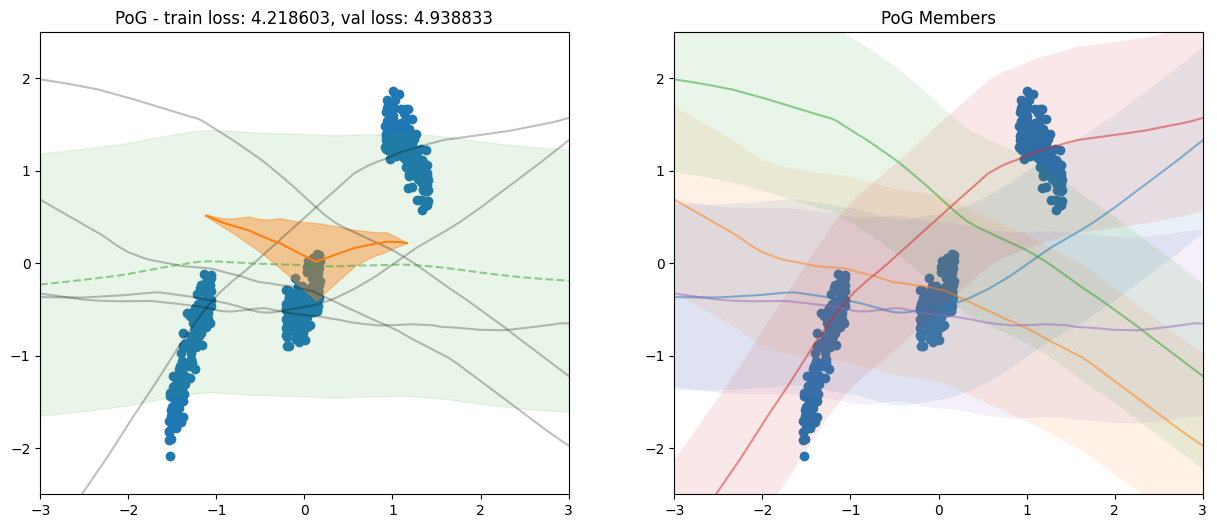

epoch:  11 - train loss: 4.09731, val loss: 4.89059, train err:    nan, val err:    nan, β: 2.1534, lr: 0.00010
epoch:  12 - train loss: 3.99726, val loss: 4.83867, train err:    nan, val err:    nan, β: 2.1612, lr: 0.00010
epoch:  13 - train loss: 3.90481, val loss: 4.78345, train err:    nan, val err:    nan, β: 2.1693, lr: 0.00010
epoch:  14 - train loss: 3.82016, val loss: 4.72611, train err:    nan, val err:    nan, β: 2.1778, lr: 0.00010
epoch:  15 - train loss: 3.74347, val loss: 4.66651, train err:    nan, val err:    nan, β: 2.1868, lr: 0.00010
epoch:  16 - train loss: 3.67391, val loss: 4.60553, train err:    nan, val err:    nan, β: 2.1962, lr: 0.00010
epoch:  17 - train loss: 3.60910, val loss: 4.54301, train err:    nan, val err:    nan, β: 2.2060, lr: 0.00010
epoch:  18 - train loss: 3.55742, val loss: 4.48048, train err:    nan, val err:    nan, β: 2.2164, lr: 0.00010
epoch:  19 - train loss: 3.50823, val loss: 4.41733, train err:    nan, val err:    nan, β: 2.2272, lr: 

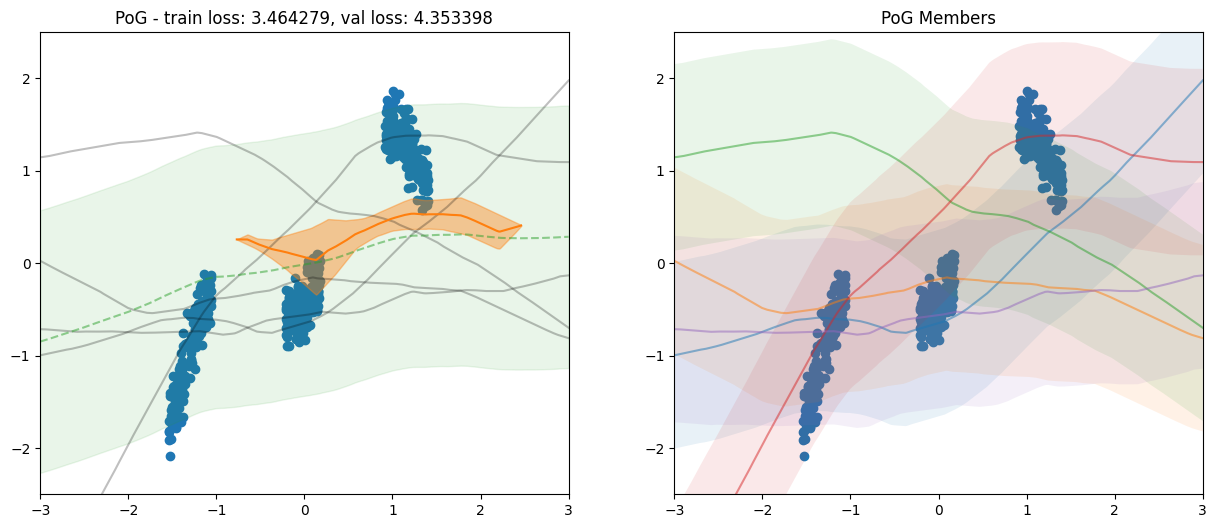

epoch:  21 - train loss: 3.42506, val loss: 4.29058, train err:    nan, val err:    nan, β: 2.2506, lr: 0.00010
epoch:  22 - train loss: 3.38996, val loss: 4.22898, train err:    nan, val err:    nan, β: 2.2631, lr: 0.00010
epoch:  23 - train loss: 3.35823, val loss: 4.16863, train err:    nan, val err:    nan, β: 2.2763, lr: 0.00010
epoch:  24 - train loss: 3.32936, val loss: 4.10971, train err:    nan, val err:    nan, β: 2.2901, lr: 0.00010
epoch:  25 - train loss: 3.30290, val loss: 4.05218, train err:    nan, val err:    nan, β: 2.3046, lr: 0.00010
epoch:  26 - train loss: 3.27847, val loss: 3.99596, train err:    nan, val err:    nan, β: 2.3197, lr: 0.00010
epoch:  27 - train loss: 3.25569, val loss: 3.94164, train err:    nan, val err:    nan, β: 2.3357, lr: 0.00010
epoch:  28 - train loss: 3.23427, val loss: 3.88949, train err:    nan, val err:    nan, β: 2.3523, lr: 0.00010
epoch:  29 - train loss: 3.21377, val loss: 3.83952, train err:    nan, val err:    nan, β: 2.3698, lr: 

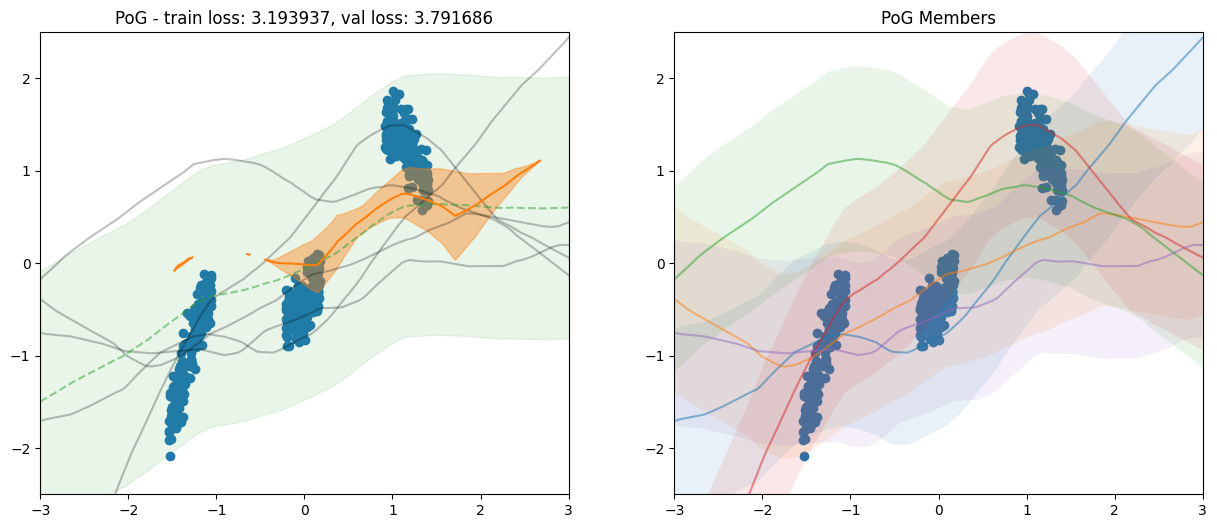

epoch:  31 - train loss: 3.17507, val loss: 3.74650, train err:    nan, val err:    nan, β: 2.4074, lr: 0.00010
epoch:  32 - train loss: 3.15673, val loss: 3.70403, train err:    nan, val err:    nan, β: 2.4276, lr: 0.00010
epoch:  33 - train loss: 3.13879, val loss: 3.66407, train err:    nan, val err:    nan, β: 2.4487, lr: 0.00010
epoch:  34 - train loss: 3.12116, val loss: 3.62645, train err:    nan, val err:    nan, β: 2.4708, lr: 0.00010
epoch:  35 - train loss: 3.10377, val loss: 3.59103, train err:    nan, val err:    nan, β: 2.4940, lr: 0.00010
epoch:  36 - train loss: 3.08658, val loss: 3.55777, train err:    nan, val err: 0.5514, β: 2.5182, lr: 0.00010
epoch:  37 - train loss: 3.06943, val loss: 3.52643, train err:    nan, val err: 0.5249, β: 2.5436, lr: 0.00010
epoch:  38 - train loss: 3.05222, val loss: 3.49687, train err:    nan, val err: 0.5007, β: 2.5702, lr: 0.00010
epoch:  39 - train loss: 3.03575, val loss: 3.46872, train err: 0.0796, val err: 0.4782, β: 2.5981, lr: 

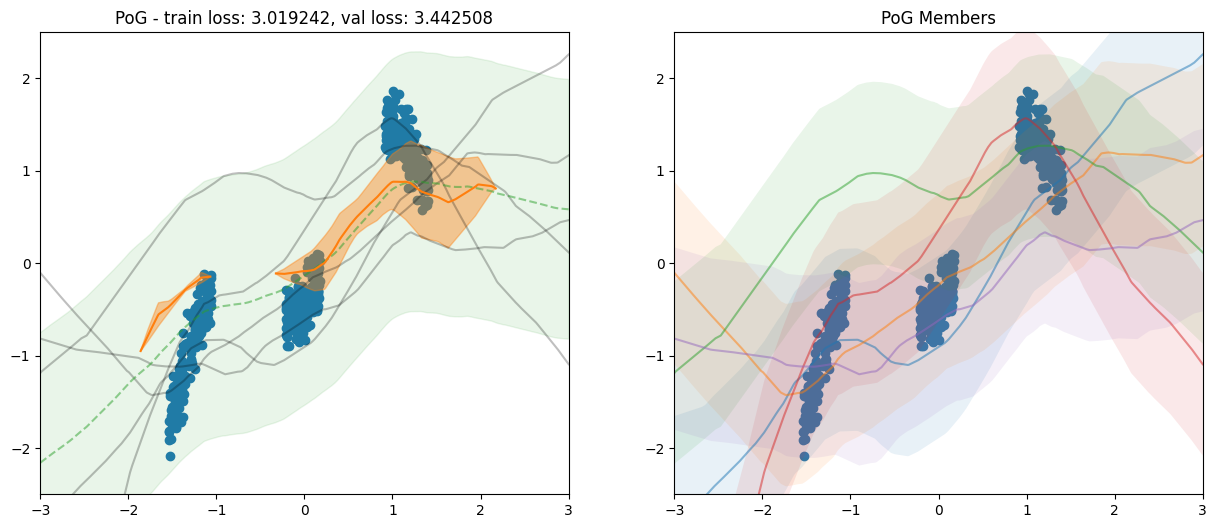

epoch:  41 - train loss: 3.00271, val loss: 3.41797, train err: 0.0768, val err: 0.4394, β: 2.6577, lr: 0.00010
epoch:  42 - train loss: 2.98625, val loss: 3.39462, train err: 0.0753, val err: 0.4224, β: 2.6896, lr: 0.00010
epoch:  43 - train loss: 2.96997, val loss: 3.37220, train err: 0.0739, val err: 0.4062, β: 2.7230, lr: 0.00010
epoch:  44 - train loss: 2.95374, val loss: 3.35029, train err: 0.0725, val err: 0.3909, β: 2.7578, lr: 0.00010
epoch:  45 - train loss: 2.93772, val loss: 3.32922, train err: 0.0712, val err: 0.3767, β: 2.7943, lr: 0.00010
epoch:  46 - train loss: 2.92175, val loss: 3.30912, train err: 0.0699, val err: 0.3638, β: 2.8324, lr: 0.00010
epoch:  47 - train loss: 2.90589, val loss: 3.28949, train err: 0.0686, val err: 0.3519, β: 2.8722, lr: 0.00010
epoch:  48 - train loss: 2.89014, val loss: 3.26976, train err: 0.0674, val err: 0.3407, β: 2.9138, lr: 0.00010
epoch:  49 - train loss: 2.87447, val loss: 3.24984, train err: 0.0661, val err: 0.3298, β: 2.9572, lr: 

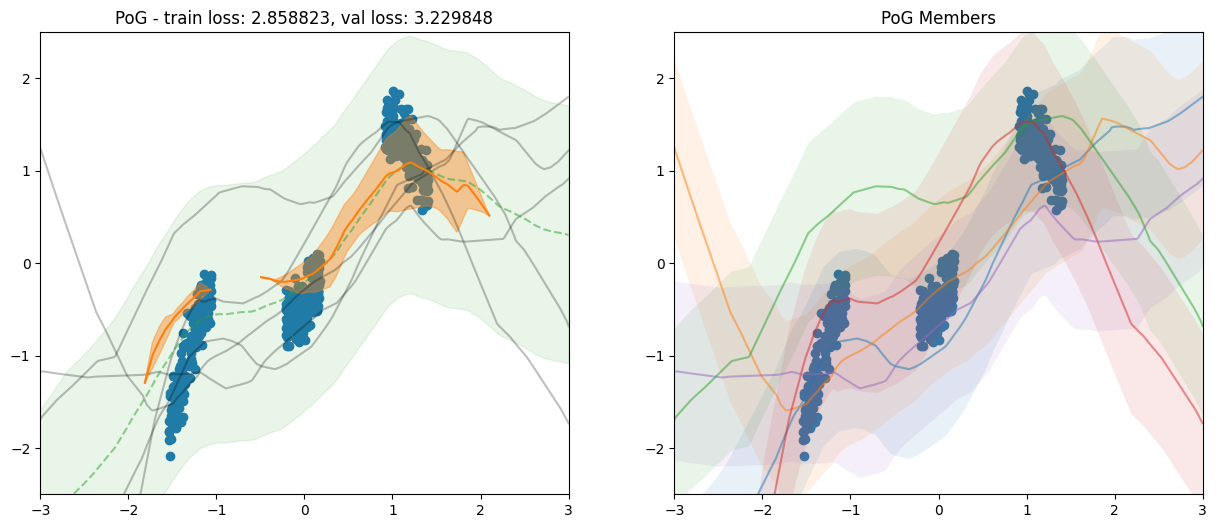

epoch:  51 - train loss: 2.84322, val loss: 3.20900, train err: 0.0636, val err: 0.3094, β: 3.0499, lr: 0.00010
epoch:  52 - train loss: 2.82761, val loss: 3.18715, train err: 0.0623, val err: 0.2991, β: 3.0992, lr: 0.00010
epoch:  53 - train loss: 2.81203, val loss: 3.16442, train err: 0.0610, val err: 0.2890, β: 3.1507, lr: 0.00010
epoch:  54 - train loss: 2.79646, val loss: 3.14159, train err: 0.0597, val err: 0.2794, β: 3.2043, lr: 0.00010
epoch:  55 - train loss: 2.78091, val loss: 3.11873, train err: 0.0584, val err: 0.2703, β: 3.2602, lr: 0.00010
epoch:  56 - train loss: 2.76541, val loss: 3.09627, train err: 0.0572, val err: 0.2617, β: 3.3185, lr: 0.00010
epoch:  57 - train loss: 2.75000, val loss: 3.07415, train err: 0.0559, val err: 0.2533, β: 3.3791, lr: 0.00010
epoch:  58 - train loss: 2.73466, val loss: 3.05233, train err: 0.0548, val err: 0.2453, β: 3.4422, lr: 0.00010
epoch:  59 - train loss: 2.71941, val loss: 3.03096, train err: 0.0536, val err: 0.2377, β: 3.5078, lr: 

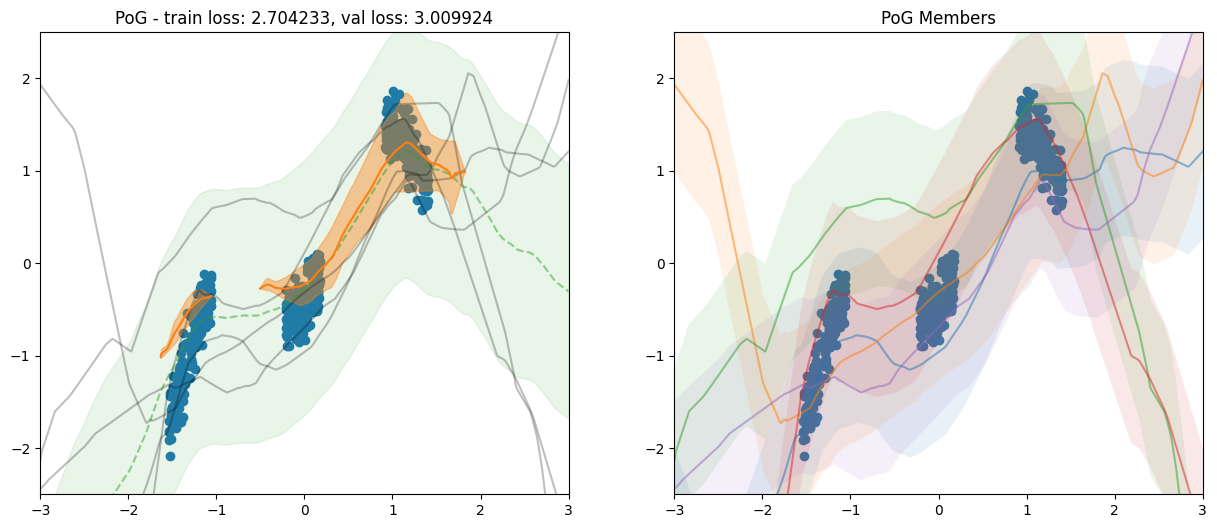

epoch:  61 - train loss: 2.68916, val loss: 2.98937, train err: 0.0515, val err: 0.2232, β: 3.6470, lr: 0.00010
epoch:  62 - train loss: 2.67420, val loss: 2.96927, train err: 0.0505, val err: 0.2164, β: 3.7207, lr: 0.00010
epoch:  63 - train loss: 2.65937, val loss: 2.94967, train err: 0.0496, val err: 0.2098, β: 3.7972, lr: 0.00010
epoch:  64 - train loss: 2.64472, val loss: 2.93025, train err: 0.0488, val err: 0.2032, β: 3.8766, lr: 0.00010
epoch:  65 - train loss: 2.63023, val loss: 2.91105, train err: 0.0480, val err: 0.1964, β: 3.9589, lr: 0.00010
epoch:  66 - train loss: 2.61588, val loss: 2.89176, train err: 0.0473, val err: 0.1899, β: 4.0443, lr: 0.00010
epoch:  67 - train loss: 2.60170, val loss: 2.87244, train err: 0.0467, val err: 0.1836, β: 4.1327, lr: 0.00010
epoch:  68 - train loss: 2.58767, val loss: 2.85301, train err: 0.0461, val err: 0.1776, β: 4.2242, lr: 0.00010
epoch:  69 - train loss: 2.57380, val loss: 2.83355, train err: 0.0456, val err: 0.1716, β: 4.3188, lr: 

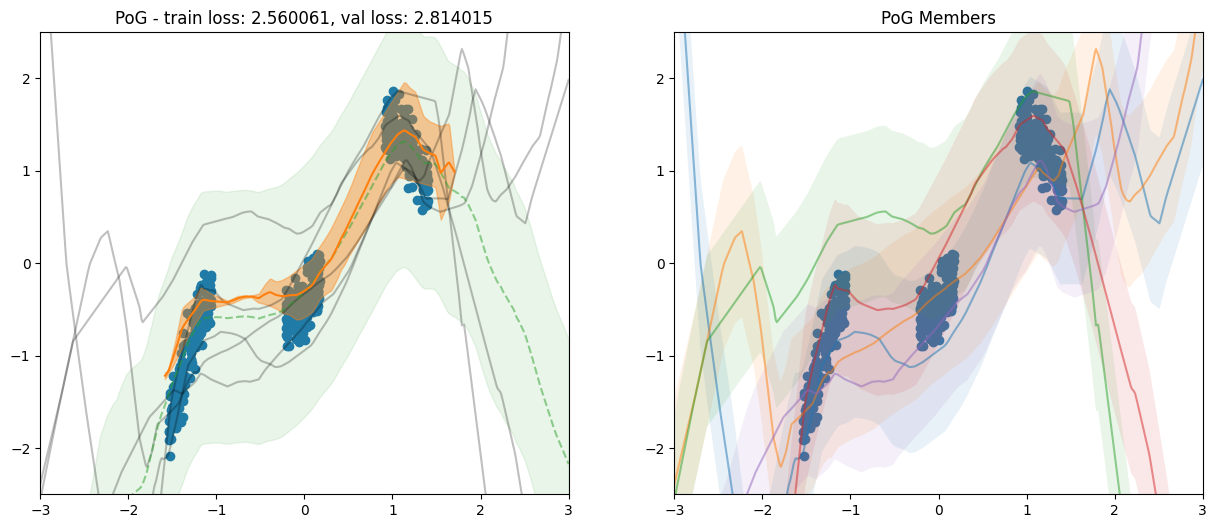

epoch:  71 - train loss: 2.54649, val loss: 2.79408, train err: 0.0448, val err: 0.1593, β: 4.5178, lr: 0.00010
epoch:  72 - train loss: 2.53305, val loss: 2.77389, train err: 0.0444, val err: 0.1532, β: 4.6222, lr: 0.00010
epoch:  73 - train loss: 2.51971, val loss: 2.75357, train err: 0.0440, val err: 0.1471, β: 4.7299, lr: 0.00010
epoch:  74 - train loss: 2.50648, val loss: 2.73305, train err: 0.0437, val err: 0.1410, β: 4.8408, lr: 0.00010
epoch:  75 - train loss: 2.49340, val loss: 2.71227, train err: 0.0434, val err: 0.1348, β: 4.9552, lr: 0.00010
epoch:  76 - train loss: 2.48046, val loss: 2.69107, train err: 0.0431, val err: 0.1287, β: 5.0728, lr: 0.00010
epoch:  77 - train loss: 2.46767, val loss: 2.66933, train err: 0.0429, val err: 0.1227, β: 5.1938, lr: 0.00010
epoch:  78 - train loss: 2.45501, val loss: 2.64692, train err: 0.0426, val err: 0.1169, β: 5.3181, lr: 0.00010
epoch:  79 - train loss: 2.44246, val loss: 2.62398, train err: 0.0424, val err: 0.1112, β: 5.4457, lr: 

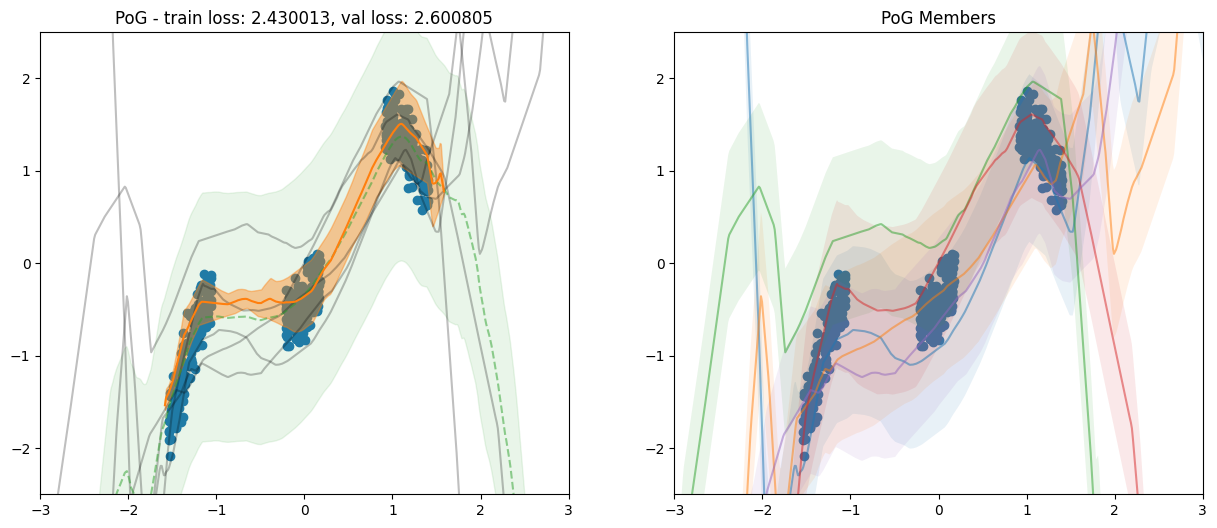

epoch:  81 - train loss: 2.41766, val loss: 2.57699, train err: 0.0419, val err: 0.1000, β: 5.7107, lr: 0.00010
epoch:  82 - train loss: 2.40542, val loss: 2.55186, train err: 0.0416, val err: 0.0941, β: 5.8479, lr: 0.00010
epoch:  83 - train loss: 2.39328, val loss: 2.52695, train err: 0.0413, val err: 0.0884, β: 5.9883, lr: 0.00010
epoch:  84 - train loss: 2.38123, val loss: 2.50124, train err: 0.0410, val err: 0.0827, β: 6.1317, lr: 0.00010
epoch:  85 - train loss: 2.36928, val loss: 2.47159, train err: 0.0407, val err: 0.0769, β: 6.2780, lr: 0.00010
epoch:  86 - train loss: 2.35742, val loss: 2.44385, train err: 0.0405, val err: 0.0716, β: 6.4272, lr: 0.00010
epoch:  87 - train loss: 2.34565, val loss: 2.41823, train err: 0.0402, val err: 0.0667, β: 6.5792, lr: 0.00010
epoch:  88 - train loss: 2.33398, val loss: 2.39472, train err: 0.0399, val err: 0.0624, β: 6.7338, lr: 0.00010
epoch:  89 - train loss: 2.32240, val loss: 2.37331, train err: 0.0396, val err: 0.0584, β: 6.8909, lr: 

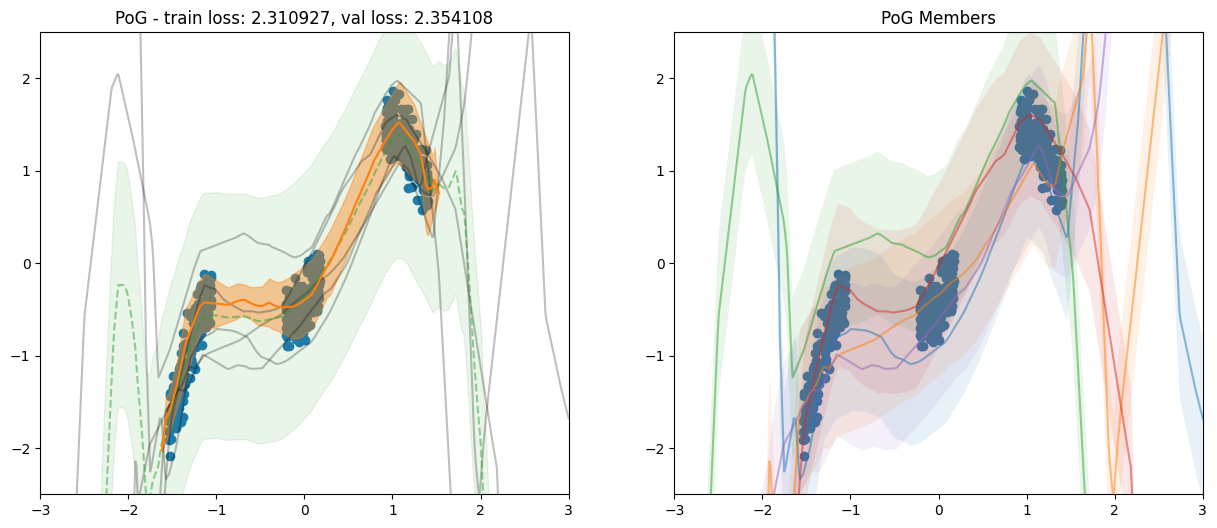

epoch:  91 - train loss: 2.29955, val loss: 2.33680, train err: 0.0390, val err: 0.0525, β: 7.2121, lr: 0.00010
epoch:  92 - train loss: 2.28828, val loss: 2.32099, train err: 0.0388, val err: 0.0502, β: 7.3759, lr: 0.00010
epoch:  93 - train loss: 2.27708, val loss: 2.30637, train err: 0.0385, val err: 0.0486, β: 7.5416, lr: 0.00010
epoch:  94 - train loss: 2.26596, val loss: 2.29269, train err: 0.0383, val err: 0.0473, β: 7.7090, lr: 0.00010
epoch:  95 - train loss: 2.25493, val loss: 2.27972, train err: 0.0381, val err: 0.0463, β: 7.8779, lr: 0.00010
epoch:  96 - train loss: 2.24396, val loss: 2.26731, train err: 0.0379, val err: 0.0454, β: 8.0482, lr: 0.00010
epoch:  97 - train loss: 2.23307, val loss: 2.25535, train err: 0.0377, val err: 0.0447, β: 8.2197, lr: 0.00010
epoch:  98 - train loss: 2.22225, val loss: 2.24375, train err: 0.0376, val err: 0.0440, β: 8.3921, lr: 0.00010
epoch:  99 - train loss: 2.21151, val loss: 2.23245, train err: 0.0374, val err: 0.0435, β: 8.5652, lr: 

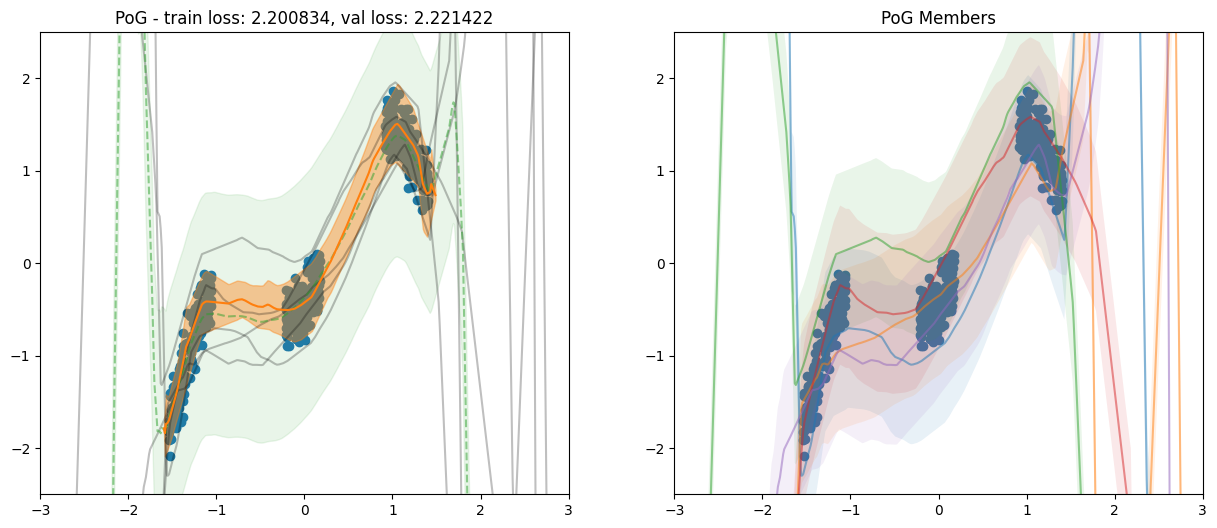

epoch: 101 - train loss: 2.19023, val loss: 2.21062, train err: 0.0371, val err: 0.0426, β: 8.9129, lr: 0.00010
epoch: 102 - train loss: 2.17970, val loss: 2.20003, train err: 0.0369, val err: 0.0421, β: 9.0871, lr: 0.00010
epoch: 103 - train loss: 2.16924, val loss: 2.18963, train err: 0.0368, val err: 0.0417, β: 9.2611, lr: 0.00010
epoch: 104 - train loss: 2.15886, val loss: 2.17941, train err: 0.0366, val err: 0.0414, β: 9.4348, lr: 0.00010
epoch: 105 - train loss: 2.14853, val loss: 2.16939, train err: 0.0364, val err: 0.0410, β: 9.6079, lr: 0.00010
epoch: 106 - train loss: 2.13828, val loss: 2.15958, train err: 0.0362, val err: 0.0407, β: 9.7803, lr: 0.00010
epoch: 107 - train loss: 2.12806, val loss: 2.14993, train err: 0.0360, val err: 0.0403, β: 9.9518, lr: 0.00010
epoch: 108 - train loss: 2.11786, val loss: 2.14076, train err: 0.0358, val err: 0.0399, β: 10.1221, lr: 0.00010
epoch: 109 - train loss: 2.10768, val loss: 2.13196, train err: 0.0356, val err: 0.0396, β: 10.2910, lr

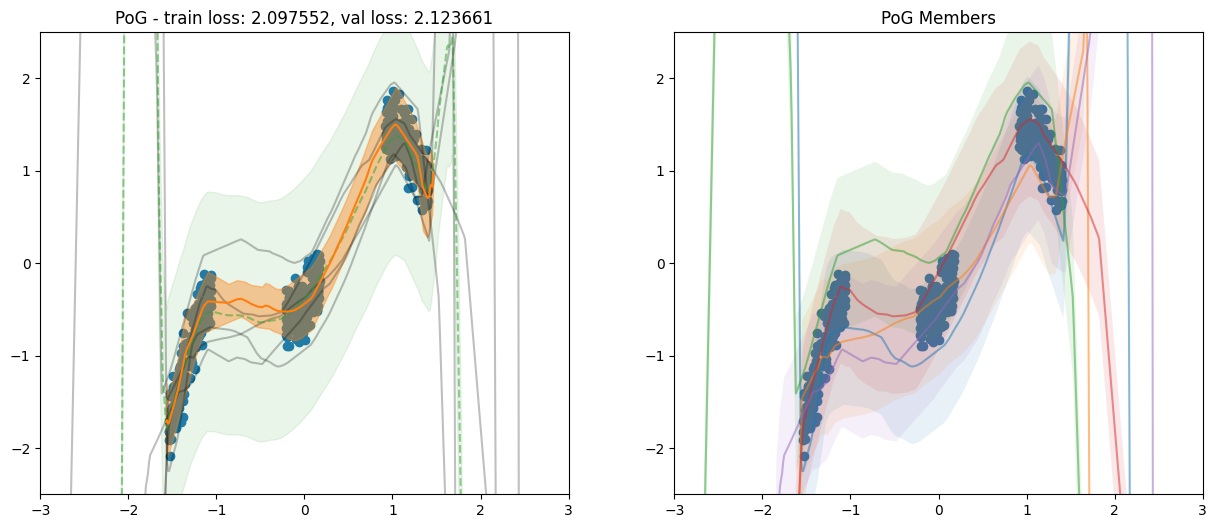

epoch: 111 - train loss: 2.08749, val loss: 2.11595, train err: 0.0349, val err: 0.0391, β: 10.6241, lr: 0.00010
epoch: 112 - train loss: 2.07749, val loss: 2.10884, train err: 0.0346, val err: 0.0390, β: 10.7879, lr: 0.00010
epoch: 113 - train loss: 2.06757, val loss: 2.10242, train err: 0.0342, val err: 0.0389, β: 10.9496, lr: 0.00010
epoch: 114 - train loss: 2.05776, val loss: 2.09678, train err: 0.0339, val err: 0.0390, β: 11.1091, lr: 0.00010
epoch: 115 - train loss: 2.04807, val loss: 2.09208, train err: 0.0337, val err: 0.0391, β: 11.2662, lr: 0.00010
epoch: 116 - train loss: 2.03852, val loss: 2.08848, train err: 0.0334, val err: 0.0393, β: 11.4208, lr: 0.00010
epoch: 117 - train loss: 2.02911, val loss: 2.08608, train err: 0.0333, val err: 0.0396, β: 11.5728, lr: 0.00010
epoch: 118 - train loss: 2.01985, val loss: 2.08484, train err: 0.0332, val err: 0.0398, β: 11.7220, lr: 0.00010
epoch: 119 - train loss: 2.01076, val loss: 2.08429, train err: 0.0331, val err: 0.0400, β: 11.8

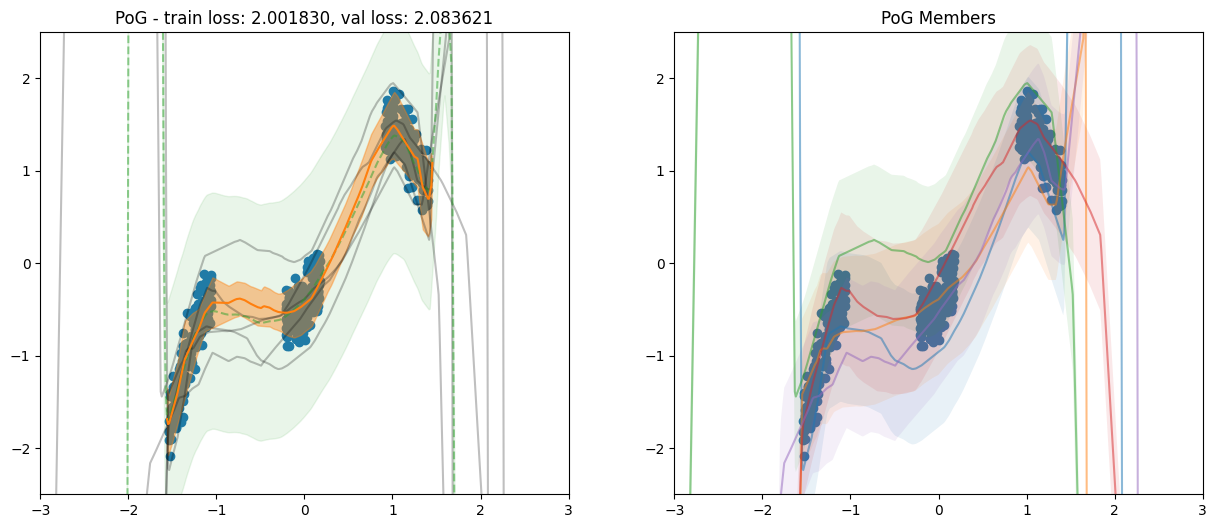

epoch: 121 - train loss: 1.99304, val loss: 2.08184, train err: 0.0330, val err: 0.0403, β: 12.1521, lr: 0.00010
epoch: 122 - train loss: 1.98437, val loss: 2.07752, train err: 0.0329, val err: 0.0402, β: 12.2893, lr: 0.00010
epoch: 123 - train loss: 1.97576, val loss: 2.06998, train err: 0.0329, val err: 0.0401, β: 12.4234, lr: 0.00010
epoch: 124 - train loss: 1.96716, val loss: 2.05981, train err: 0.0328, val err: 0.0399, β: 12.5543, lr: 0.00010
epoch: 125 - train loss: 1.95859, val loss: 2.04786, train err: 0.0327, val err: 0.0396, β: 12.6819, lr: 0.00010
epoch: 126 - train loss: 1.95005, val loss: 2.03567, train err: 0.0326, val err: 0.0393, β: 12.8062, lr: 0.00010
epoch: 127 - train loss: 1.94157, val loss: 2.02437, train err: 0.0325, val err: 0.0389, β: 12.9272, lr: 0.00010
epoch: 128 - train loss: 1.93318, val loss: 2.01441, train err: 0.0325, val err: 0.0386, β: 13.0448, lr: 0.00010
epoch: 129 - train loss: 1.92488, val loss: 2.00587, train err: 0.0324, val err: 0.0383, β: 13.1

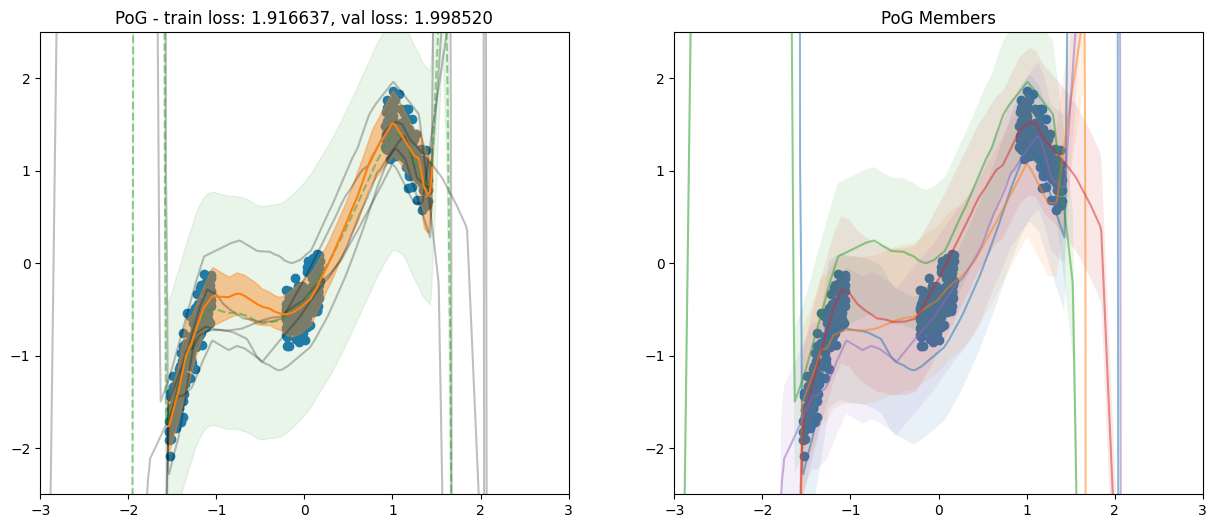

epoch: 131 - train loss: 1.90846, val loss: 1.99204, train err: 0.0324, val err: 0.0381, β: 13.3778, lr: 0.00010
epoch: 132 - train loss: 1.90035, val loss: 1.98602, train err: 0.0323, val err: 0.0381, β: 13.4822, lr: 0.00010
epoch: 133 - train loss: 1.89226, val loss: 1.98003, train err: 0.0323, val err: 0.0382, β: 13.5833, lr: 0.00010
epoch: 134 - train loss: 1.88420, val loss: 1.97393, train err: 0.0323, val err: 0.0383, β: 13.6812, lr: 0.00010
epoch: 135 - train loss: 1.87615, val loss: 1.96765, train err: 0.0322, val err: 0.0385, β: 13.7758, lr: 0.00010
epoch: 136 - train loss: 1.86813, val loss: 1.96123, train err: 0.0322, val err: 0.0387, β: 13.8673, lr: 0.00010
epoch: 137 - train loss: 1.86013, val loss: 1.95475, train err: 0.0322, val err: 0.0389, β: 13.9557, lr: 0.00010
epoch: 138 - train loss: 1.85217, val loss: 1.94842, train err: 0.0321, val err: 0.0391, β: 14.0411, lr: 0.00010
epoch: 139 - train loss: 1.84430, val loss: 1.94229, train err: 0.0321, val err: 0.0392, β: 14.1

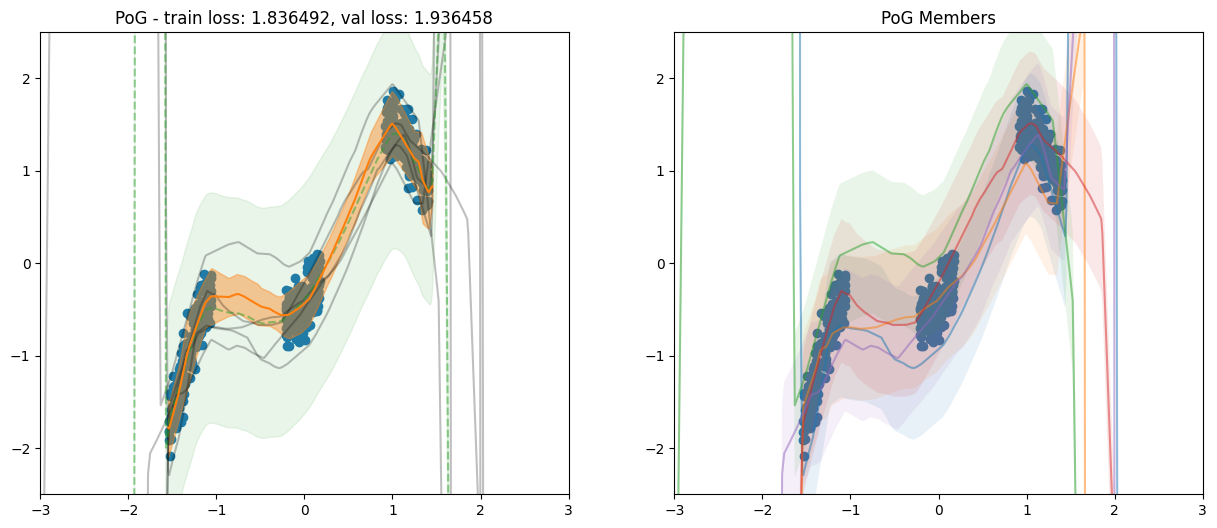

epoch: 141 - train loss: 1.82867, val loss: 1.93114, train err: 0.0321, val err: 0.0395, β: 14.2793, lr: 0.00010
epoch: 142 - train loss: 1.82088, val loss: 1.92600, train err: 0.0320, val err: 0.0396, β: 14.3530, lr: 0.00010
epoch: 143 - train loss: 1.81316, val loss: 1.92264, train err: 0.0320, val err: 0.0397, β: 14.4239, lr: 0.00010
Best val_err
epoch: 144 - train loss: 1.80549, val loss: 1.91963, train err: 0.0320, val err: 0.0398, β: 14.4922, lr: 0.00010
epoch: 145 - train loss: 1.79785, val loss: 1.91690, train err: 0.0320, val err: 0.0399, β: 14.5578, lr: 0.00010
epoch: 146 - train loss: 1.79024, val loss: 1.91428, train err: 0.0320, val err: 0.0400, β: 14.6209, lr: 0.00010
epoch: 147 - train loss: 1.78265, val loss: 1.91191, train err: 0.0319, val err: 0.0401, β: 14.6815, lr: 0.00010
epoch: 148 - train loss: 1.77510, val loss: 1.90947, train err: 0.0319, val err: 0.0401, β: 14.7398, lr: 0.00010
epoch: 149 - train loss: 1.76760, val loss: 1.90711, train err: 0.0319, val err: 0.

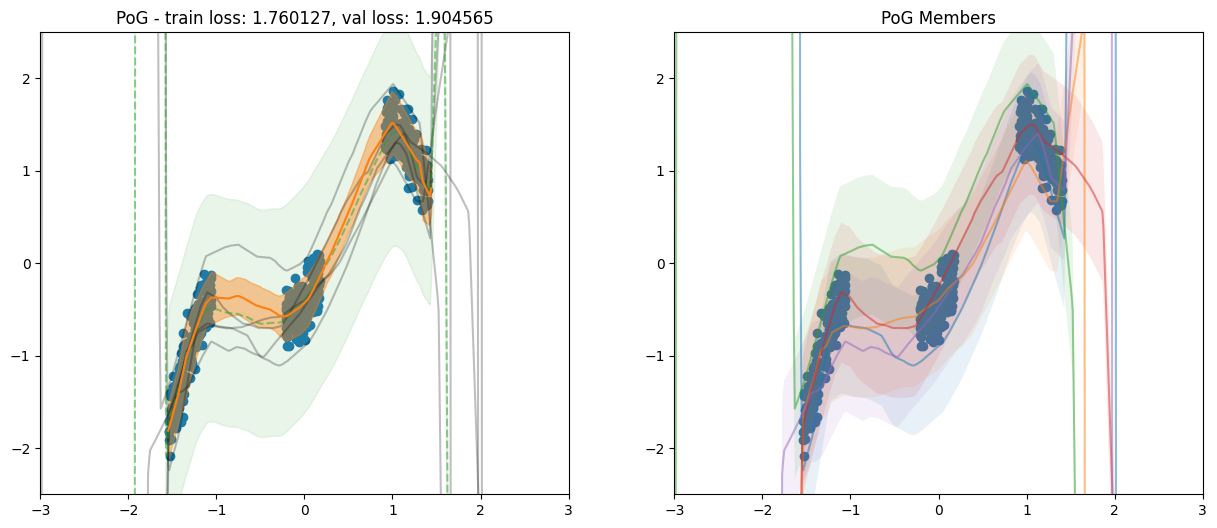

epoch: 151 - train loss: 1.75269, val loss: 1.90199, train err: 0.0318, val err: 0.0402, β: 14.9008, lr: 0.00010
epoch: 152 - train loss: 1.74528, val loss: 1.89936, train err: 0.0318, val err: 0.0403, β: 14.9501, lr: 0.00010
epoch: 153 - train loss: 1.73790, val loss: 1.89662, train err: 0.0318, val err: 0.0403, β: 14.9974, lr: 0.00010
epoch: 154 - train loss: 1.73056, val loss: 1.89354, train err: 0.0317, val err: 0.0403, β: 15.0428, lr: 0.00010
epoch: 155 - train loss: 1.72324, val loss: 1.89020, train err: 0.0317, val err: 0.0403, β: 15.0862, lr: 0.00010
epoch: 156 - train loss: 1.71597, val loss: 1.88682, train err: 0.0317, val err: 0.0403, β: 15.1278, lr: 0.00010
epoch: 157 - train loss: 1.70872, val loss: 1.88330, train err: 0.0317, val err: 0.0402, β: 15.1676, lr: 0.00010
epoch: 158 - train loss: 1.70151, val loss: 1.87966, train err: 0.0317, val err: 0.0402, β: 15.2057, lr: 0.00010
epoch: 159 - train loss: 1.69432, val loss: 1.87584, train err: 0.0317, val err: 0.0402, β: 15.2

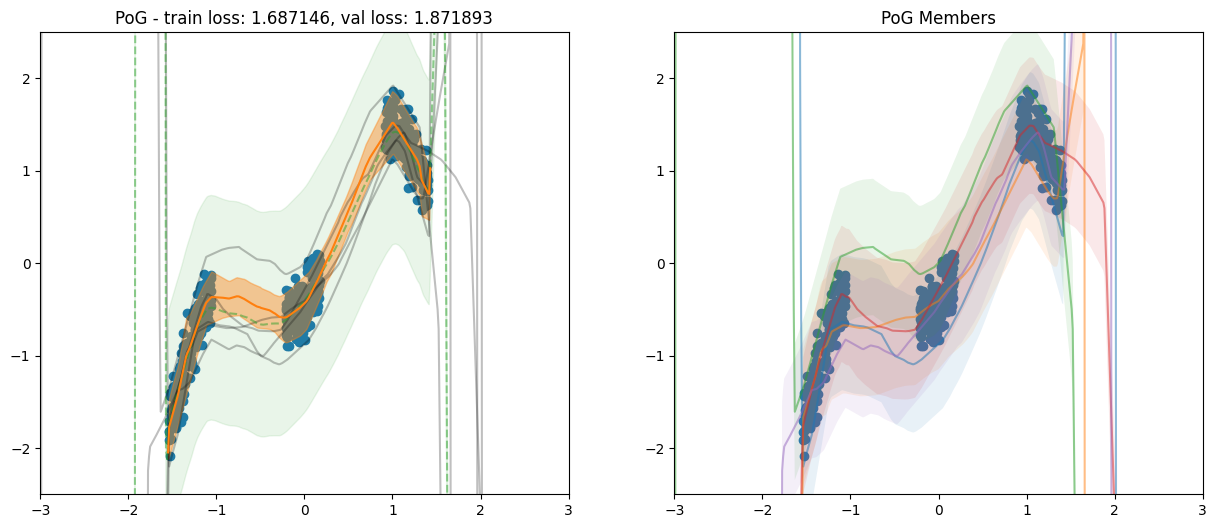

epoch: 161 - train loss: 1.68000, val loss: 1.86786, train err: 0.0316, val err: 0.0402, β: 15.3104, lr: 0.00010
epoch: 162 - train loss: 1.67285, val loss: 1.86377, train err: 0.0316, val err: 0.0401, β: 15.3423, lr: 0.00010
epoch: 163 - train loss: 1.66572, val loss: 1.85983, train err: 0.0316, val err: 0.0402, β: 15.3728, lr: 0.00010
epoch: 164 - train loss: 1.65863, val loss: 1.85604, train err: 0.0316, val err: 0.0402, β: 15.4019, lr: 0.00010
epoch: 165 - train loss: 1.65157, val loss: 1.85228, train err: 0.0316, val err: 0.0402, β: 15.4298, lr: 0.00010
epoch: 166 - train loss: 1.64453, val loss: 1.84828, train err: 0.0316, val err: 0.0403, β: 15.4564, lr: 0.00010
epoch: 167 - train loss: 1.63751, val loss: 1.84438, train err: 0.0316, val err: 0.0403, β: 15.4818, lr: 0.00010
epoch: 168 - train loss: 1.63051, val loss: 1.84035, train err: 0.0316, val err: 0.0403, β: 15.5060, lr: 0.00010
epoch: 169 - train loss: 1.62353, val loss: 1.83657, train err: 0.0316, val err: 0.0403, β: 15.5

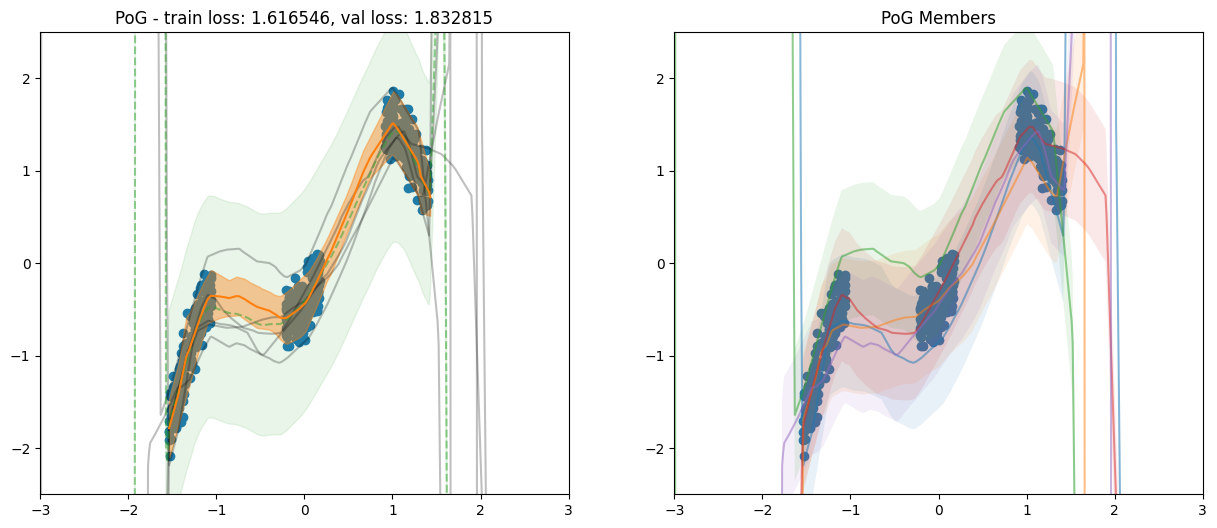

epoch: 171 - train loss: 1.60958, val loss: 1.82944, train err: 0.0316, val err: 0.0404, β: 15.5724, lr: 0.00010
epoch: 172 - train loss: 1.60263, val loss: 1.82654, train err: 0.0316, val err: 0.0404, β: 15.5926, lr: 0.00010
epoch: 173 - train loss: 1.59569, val loss: 1.82391, train err: 0.0316, val err: 0.0405, β: 15.6118, lr: 0.00010
epoch: 174 - train loss: 1.58877, val loss: 1.82164, train err: 0.0316, val err: 0.0405, β: 15.6302, lr: 0.00010
epoch: 175 - train loss: 1.58187, val loss: 1.81972, train err: 0.0316, val err: 0.0405, β: 15.6477, lr: 0.00010
epoch: 176 - train loss: 1.57495, val loss: 1.81854, train err: 0.0316, val err: 0.0406, β: 15.6643, lr: 0.00010
epoch: 177 - train loss: 1.56803, val loss: 1.81795, train err: 0.0316, val err: 0.0406, β: 15.6803, lr: 0.00010
epoch: 178 - train loss: 1.56114, val loss: 1.81774, train err: 0.0316, val err: 0.0407, β: 15.6954, lr: 0.00010
epoch: 179 - train loss: 1.55425, val loss: 1.81774, train err: 0.0316, val err: 0.0407, β: 15.7

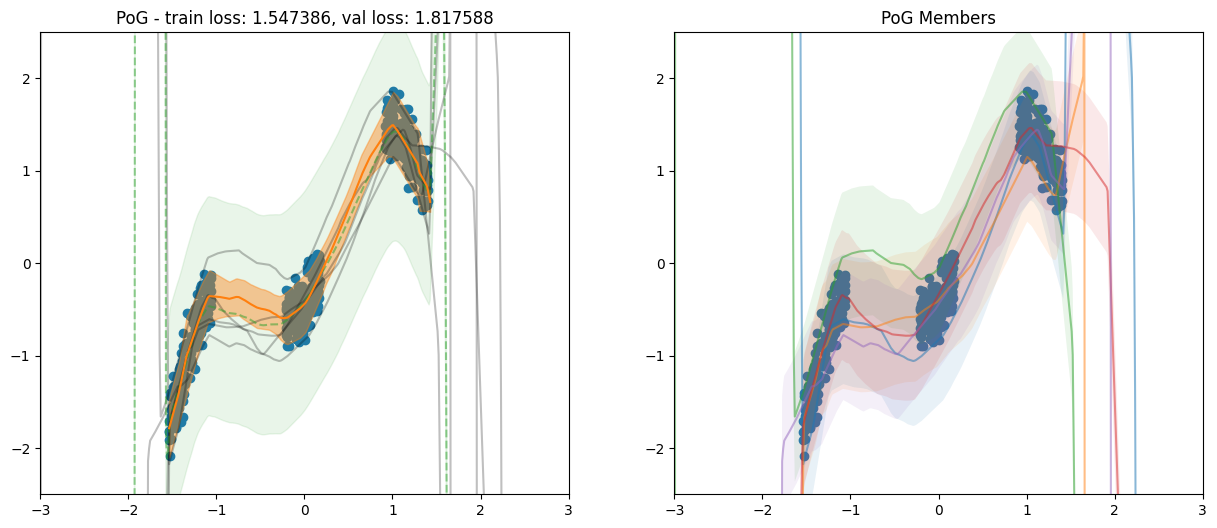

epoch: 181 - train loss: 1.54053, val loss: 1.81727, train err: 0.0316, val err: 0.0407, β: 15.7369, lr: 0.00010
epoch: 182 - train loss: 1.53368, val loss: 1.81676, train err: 0.0316, val err: 0.0407, β: 15.7494, lr: 0.00010
epoch: 183 - train loss: 1.52685, val loss: 1.81641, train err: 0.0316, val err: 0.0407, β: 15.7614, lr: 0.00010
epoch: 184 - train loss: 1.52002, val loss: 1.81620, train err: 0.0316, val err: 0.0407, β: 15.7728, lr: 0.00010
epoch: 185 - train loss: 1.51321, val loss: 1.81618, train err: 0.0316, val err: 0.0406, β: 15.7836, lr: 0.00010
epoch: 186 - train loss: 1.50639, val loss: 1.81636, train err: 0.0316, val err: 0.0406, β: 15.7940, lr: 0.00010
epoch: 187 - train loss: 1.49957, val loss: 1.81656, train err: 0.0316, val err: 0.0405, β: 15.8038, lr: 0.00010
epoch: 188 - train loss: 1.49276, val loss: 1.81694, train err: 0.0316, val err: 0.0405, β: 15.8132, lr: 0.00010
epoch: 189 - train loss: 1.48594, val loss: 1.81837, train err: 0.0316, val err: 0.0405, β: 15.8

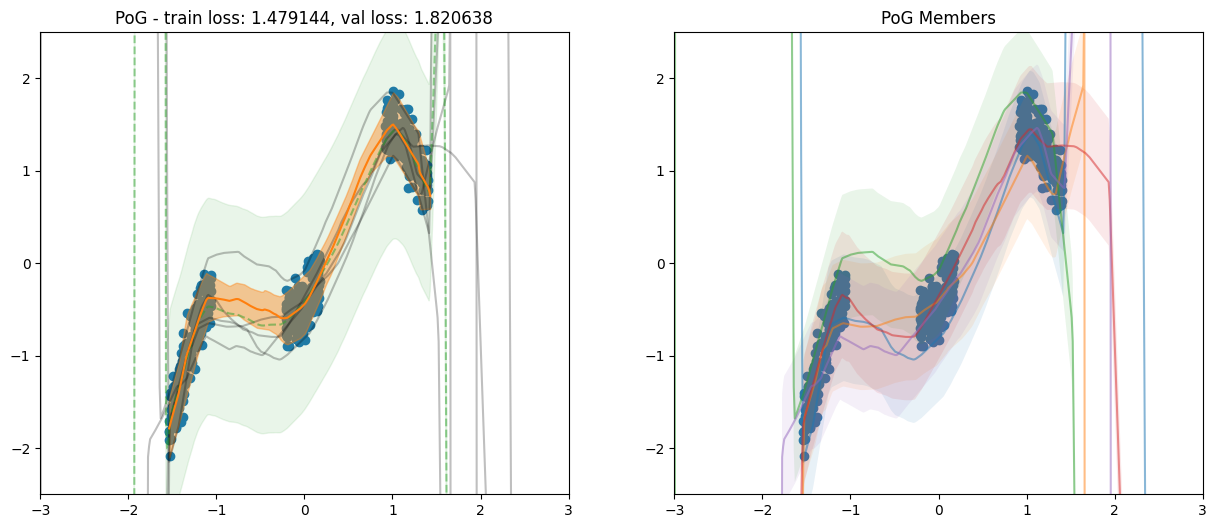

epoch: 191 - train loss: 1.47235, val loss: 1.82353, train err: 0.0316, val err: 0.0406, β: 15.8388, lr: 0.00010
epoch: 192 - train loss: 1.46556, val loss: 1.82686, train err: 0.0316, val err: 0.0407, β: 15.8466, lr: 0.00010
epoch: 193 - train loss: 1.45879, val loss: 1.83066, train err: 0.0316, val err: 0.0408, β: 15.8539, lr: 0.00010
epoch: 194 - train loss: 1.45204, val loss: 1.83517, train err: 0.0316, val err: 0.0408, β: 15.8609, lr: 0.00010
epoch: 195 - train loss: 1.44531, val loss: 1.84030, train err: 0.0316, val err: 0.0409, β: 15.8676, lr: 0.00010
epoch: 196 - train loss: 1.43859, val loss: 1.84594, train err: 0.0316, val err: 0.0411, β: 15.8740, lr: 0.00010
epoch: 197 - train loss: 1.43188, val loss: 1.85181, train err: 0.0316, val err: 0.0411, β: 15.8801, lr: 0.00010
epoch: 198 - train loss: 1.42520, val loss: 1.85779, train err: 0.0316, val err: 0.0412, β: 15.8858, lr: 0.00010
epoch: 199 - train loss: 1.41852, val loss: 1.86371, train err: 0.0316, val err: 0.0413, β: 15.8

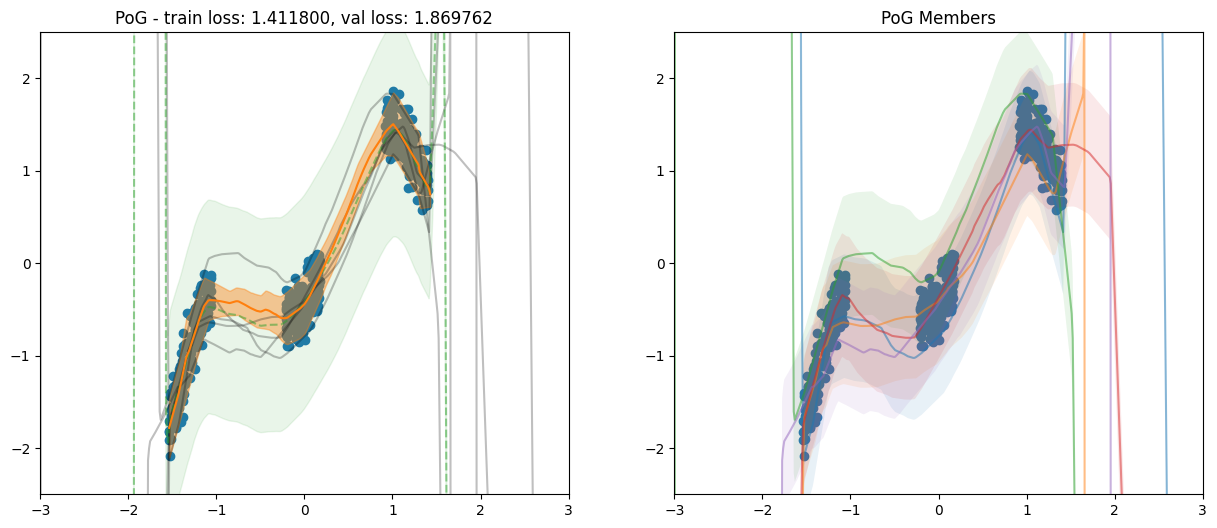

epoch: 201 - train loss: 1.40511, val loss: 1.87570, train err: 0.0316, val err: 0.0413, β: 15.9016, lr: 0.00010


In [13]:
state, best_state = train_loop(
    model, state, config, rng, partial(make_loss, per_member_loss=True), partial(make_loss, per_member_loss=True), train_loader, val_loader,
    # test_loader,
    wandb_kwargs={
        'mode': 'online',
        # 'notes': 'per member loss (annealed)',
    },
    plot_fn=make_plots,
)

## Paper Plots

In [14]:
text_width = 6.75133 # in  --> Confirmed with template explanation
line_width = 3.25063
dpi = 400

fs_m1 = 7  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/tmp/ipykernel_29296/821981954.py:20: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [15]:
xs = jnp.linspace(-2.25, 2.25, num=501)

# pog preds
pred_fun = partial(
    model.apply,
    {"params": best_state.params, **best_state.model_state},
    train=False, return_ens_preds=True,
    method=model.pred
)
_, (locs, scales) = jax.vmap(
    pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
)(xs.reshape(-1, 1))

X_train, y_train = list(zip(*train_loader.dataset))

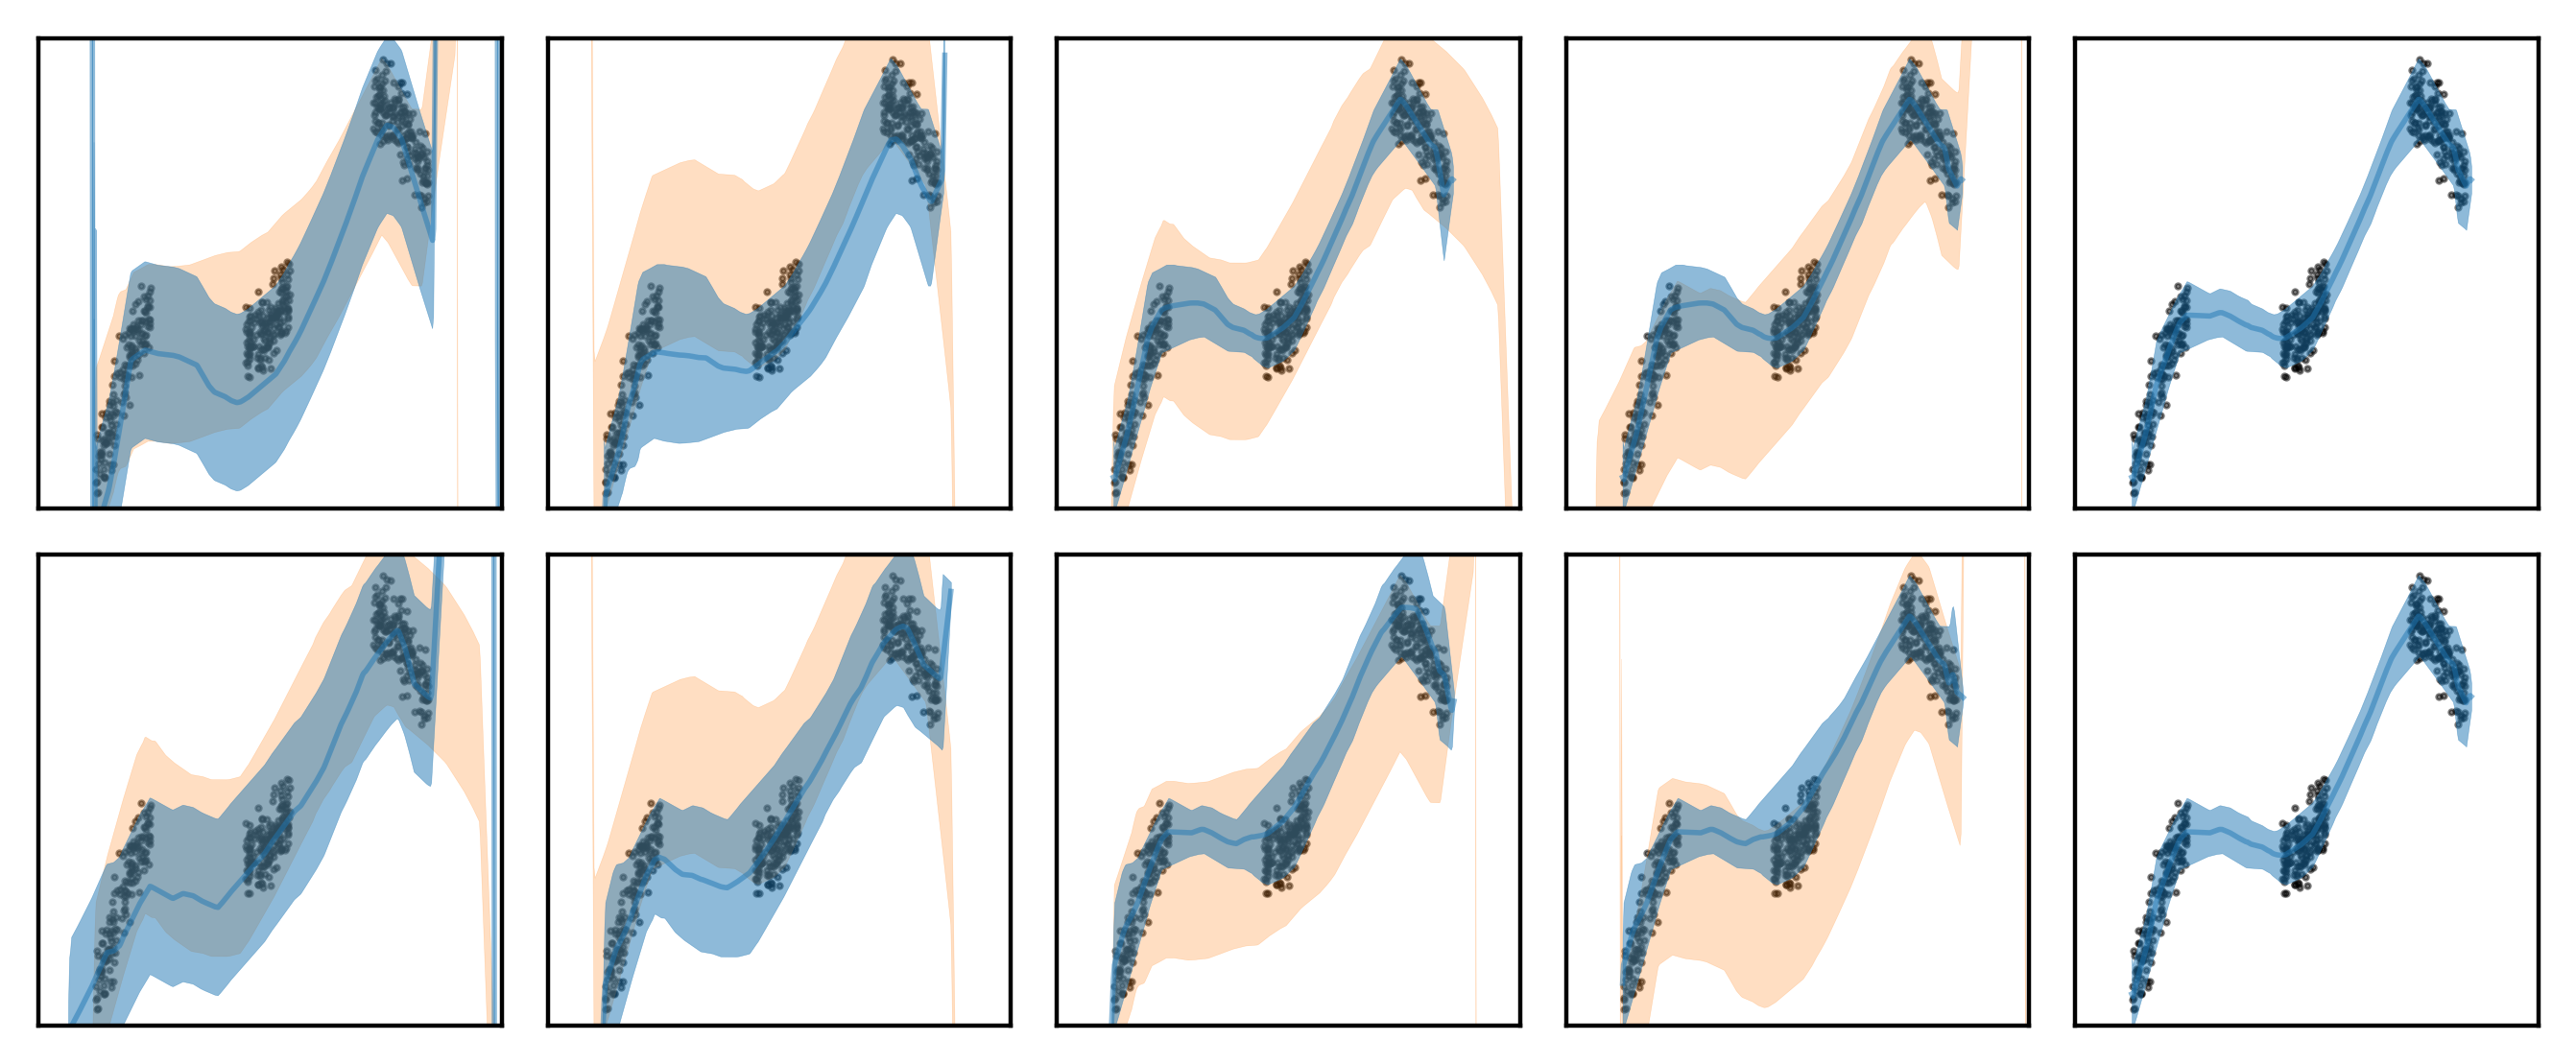

In [16]:
fig, axs = plt.subplots(2, 5, figsize=(text_width, text_width/2.4), dpi=dpi, sharey=True, sharex=True, layout='tight')

ORDER = [jnp.array([0, 1, 2, 3, 4]), jnp.array([4, 3, 2, 1, 0])]

for r, axrow in enumerate(axs):
    for c, ax in enumerate(axrow):
        ax.scatter(X_train, y_train, c='k', s=1, lw=0.5, alpha=0.5)

        # for j in range(c + 2, config.model.size):
        #     ax.plot(xs, locs[ORDER[r][j]] + scales[ORDER[r][j]], '--', c=f'C{ORDER[r][j] + 2}', alpha=0.4, lw=0.4)
        #     ax.plot(xs, locs[ORDER[r][j]] - scales[ORDER[r][j]], '--', c=f'C{ORDER[r][j] + 2}', alpha=0.4, lw=0.4)

        if c + 1 < len(axrow):
            ax.fill_between(
                xs,
                locs[ORDER[r][c+1], :, 0] - scales[ORDER[r][c+1], :, 0],
                locs[ORDER[r][c+1], :, 0] + scales[ORDER[r][c+1], :, 0],
                color='C1', alpha=0.25, lw=0.1
            )

        loc, scale = calculate_pog_loc_scale(locs[ORDER[r][:c+1], :, 0], scales[ORDER[r][:c+1], :, 0])
        ax.plot(xs, loc, c='C0', lw=1, alpha=0.5)
        ax.fill_between(xs, loc - scale, loc + scale, color='C0', alpha=0.5, lw=0.1)

        ax.set_ylim(-2.05, 2.05)
        ax.set_xlim(-2.05, 2.05)
        ax.tick_params(bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        # ax.grid(0.3)

plt.savefig('toy_evolution.pdf', dpi=dpi, bbox_inches='tight')